# Fourier analysis

1. Load the PKL file containing resampled P
2. Show statistics of signals
2. Calculate FFT, i.e., frequency - amplitude/phase pairs
2. Select some of the frequencies and save
3. Reconstruct signal from sampled FFT
5. Compare power density spectra

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, LinearLocator, NullLocator
import matplotlib.patheffects as pe
import pickle

from math import pi
from scipy.signal import welch

from util_functions import sci_notation
from util_functions import set_matplotlib_customization

In [21]:
set_matplotlib_customization(plt)

# Load data
RAWFILE = "pickledData/PTX(3).pkl"
with open(RAWFILE,'rb') as f: P = pickle.load(f)


## Reconstruct signal from frequencies

Define a function that resembled the OpenFOAM operation for translating the frequencies and magnitudes into pressure signals

In [22]:
def reconstruct(time,frequencies,sampled_dft,scale):
    # Set shape of signal
    signal = np.zeros_like(time)
    
    # Inverse FFT?
    for f,a in zip(frequencies,sampled_dft):
        if f == 0:
            signal += a.real/2.0
        else:
            signal += a.real * np.cos(time*2*pi*f) -\
                      a.imag * np.sin(time*2*pi*f)

    # Normalize the signal
    signal /= scale
    return signal

Calculate the Discrete Fourier Transform (DFT)

In [23]:
dT, nP = P.index[1] - P.index[0], len(P)
fourier = pd.DataFrame({'Freq':np.fft.rfftfreq(nP,d=dT)})
fourier.set_index("Freq",inplace=True)
for col in P: fourier[col] = np.fft.rfft(P[col])

Select a portion of frequencies to reconstruct the signal with

In [24]:
nFrequencies = 1024
sampled = fourier.iloc[:nFrequencies,:]
time_arr = np.array(list(P.index))
highestFreqCaptured = sampled.index[-1]

print("""
{:} frequencies are used for signal reconstruction
{:.2f} Hz is the highest frequency conserved
""".format(len(sampled),highestFreqCaptured))


1024 frequencies are used for signal reconstruction
6.43 Hz is the highest frequency conserved



This would be for a single point, remember there are multiple x-coordinates to analyze

In [25]:
P.columns

Float64Index([       0.0,  0.0030373, 0.00606325, 0.00907949,  0.0120884,
               0.0150927,  0.0180954,  0.0210996,  0.0241085,  0.0271246,
               0.0301503,  0.0331874,  0.0362364,  0.0392969,   0.042367,
               0.0454428,  0.0485182,  0.0515833,  0.0546233,   0.057628,
               0.0605945,  0.0635246,  0.0664228,  0.0692961,  0.0721524,
                   0.075,  0.0778476,  0.0807039,  0.0835772,  0.0864754,
               0.0894055,   0.092372,  0.0953767,  0.0984167,   0.101482,
                0.104557,   0.107633,   0.110703,   0.113764,   0.116813,
                 0.11985,   0.122875,   0.125892,   0.128901,   0.131905,
                0.134907,   0.137911,    0.14092,   0.143937,   0.146963,
                    0.15],
             dtype='float64')

### Reconstruct one signal to visualize

Choosing x[16] as it represents the most problematic in terms of energy lost due this low-pass filtering.

In [26]:
nWhich = int(16)
Pnew = reconstruct(time_arr,sampled.index,sampled.iloc[:,nWhich],len(fourier))
Pold = P.iloc[:,nWhich]

### Plot Supplemental Figure S7

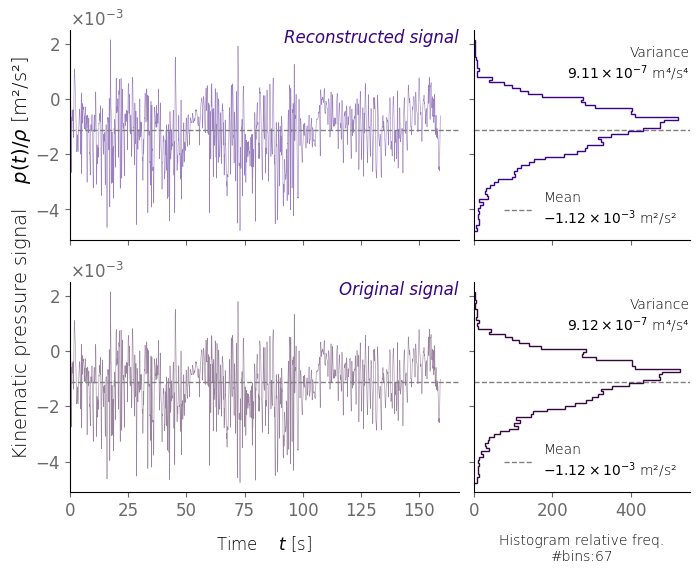

In [27]:
# Plot signals with histograms
fig, axs = plt.subplots(2, 2, sharex='col', sharey='row', figsize=[
                        8, 6], gridspec_kw={'hspace': 0.2, 'wspace':0.05, 'width_ratios':[0.9,0.5]})

# Reconstructed signal

line_dict = dict(c='xkcd:indigo', alpha=0.5, lw=0.4)
hist_dict = dict(bins='scott', density=True, histtype='step',
                 color='xkcd:indigo', orientation='horizontal')

ax = axs[0, 0]
ax.plot(P.index, Pnew, **line_dict)
ax.set_title("Reconstructed signal", color='xkcd:indigo', fontdict=dict(size=12, weight=400, style='oblique'), loc='right', y=0.9)

for ax in axs[0,:]:
    ax.axhline(Pnew.mean(), ls="dashed", c='gray', lw=1, 
        label=f"Mean\n{sci_notation(Pnew.mean())} m²/s²")

ax = axs[0, 1]
ax.hist(Pnew, **hist_dict)
ax.legend(fontsize=10, frameon=False, prop={'weight':10}, loc='lower right')
ax.text(1.0, 1.0, f"\nVariance\n{sci_notation(Pnew.var())} m⁴/s⁴", 
        transform=ax.transAxes, fontdict=dict(size=10, weight=10),
        va='top', ha='right')

# Original

line_dict = dict(c='xkcd:dark purple', alpha=0.5, lw=0.4)
hist_dict = dict(bins='scott', density=True, histtype='step',
                 color='xkcd:dark purple', orientation='horizontal')

ax = axs[1, 0]
ax.plot(P.index, Pold, **line_dict)
ax.set_title("Original signal", color='xkcd:indigo', fontdict=dict(size=12, weight=400, style='oblique'), loc='right', y=0.9)
ax.set_xlabel(r"Time $\quad t$ [s]", fontweight=10)

for ax in axs[1,:]:
    ax.axhline(Pold.mean(), ls="dashed", c='gray', lw=1,
        label=f"Mean\n{sci_notation(Pold.mean())} m²/s²")

ax = axs[1, 1]
h = ax.hist(Pold, **hist_dict)
ax.set_xlabel(f"Histogram relative freq.\n#bins:{len(h[0])}", fontdict=dict(size=10))

ax.legend(fontsize=10, frameon=False, prop={'weight':10}, loc='lower right')
ax.text(1.0, 1.0, f"\nVariance\n{sci_notation(Pold.var())} m⁴/s⁴", 
        transform=ax.transAxes, fontdict=dict(size=10, weight=10),
        va='top', ha='right')

for ax in axs[:,0]:
    ax.ticklabel_format(axis='y', scilimits=(0,0), useMathText=True)
    ax.set_xlim(left=0)

fig.supylabel(r"Kinematic pressure signal $\quad p(t)/\rho$ [m²/s²]", fontsize=14, fontweight=10, x=0.05)

#fig.savefig("SI.PressureSignalReconstructionExample.pdf",bbox_inches='tight', pad_inches=0.05)
plt.show()


### Compare power spectral density plots (Supp Fig. S8)

The power spectrum density will show the power of each of the frequencies in the signal. The area under that curve is the variance - or the total energy of the process. We are using a low-pass filter to allow only the lowest frequencies which are the ones that contribute the most to the energy of the signal. 

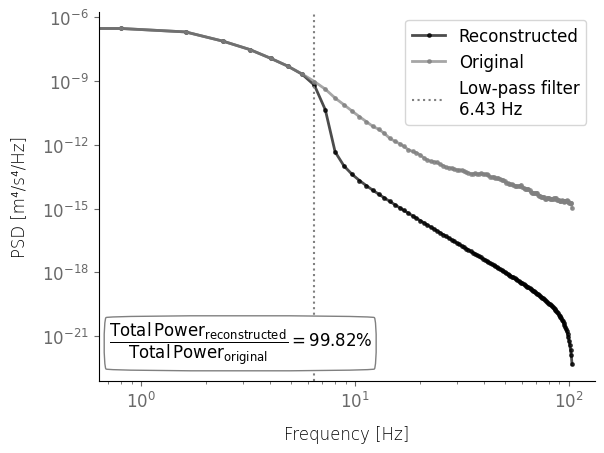

In [28]:
line_dict = dict(ls='-', marker='.', markersize=5, lw=2, alpha=0.7)
welch_dict = dict(fs=1/dT, scaling='density')
fig, ax = plt.subplots()

# Reconstructed
f, Pxx = welch(Pnew, **welch_dict)
tot_power_rebuilt = np.trapz(Pxx, f)
ax.plot(f, Pxx, label="Reconstructed", **line_dict, c='k')

# Original
f, Pxx = welch(Pold, **welch_dict)
tot_power_orig = np.trapz(Pxx, f)
ax.plot(f, Pxx, label="Original", **line_dict, c='gray')

# Total power ratio
ax.text(
    0.02, 0.04,
    r"$\dfrac{{\rm Total \, Power}_{\rm reconstructed}}{{\rm Total \, Power}_{\rm original}} = $" +
    f"{tot_power_rebuilt/tot_power_orig:.2%}",
    transform=ax.transAxes, ha='left', va='bottom', fontsize=12,
    bbox=dict(boxstyle="round4", fc="w", ec='gray', ls='-'))

# Beautify
ax.axvline(x=highestFreqCaptured, ls='dotted', c='gray',
           label=f"Low-pass filter\n{highestFreqCaptured:.2f} Hz")
ax.set(xscale='log', yscale='log',
       xlabel=r"Frequency [Hz]", ylabel=r"PSD [m⁴/s⁴/Hz]")
ax.legend(fontsize=12)

# fig.savefig("SI.PowerSpectrumDensity.pdf", bbox_inches='tight', pad_inches=0.05)
plt.show()


### Other comparisons based on the frequency spectra

Compare magnitude spectra

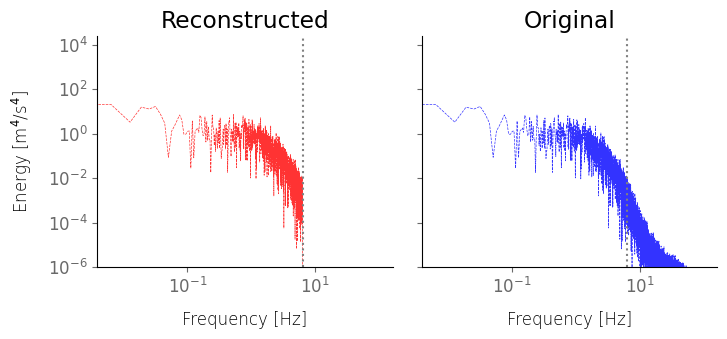

In [29]:
line_dict  = dict(ls='dashed',lw=0.5,alpha=0.8)
fig,axs = plt.subplots(1,2,sharey=True,figsize=[8,3],gridspec_kw={"wspace":0.1})

# Reconstructed
f, Sxx = np.fft.rfftfreq(len(Pnew),d=dT), np.absolute(np.fft.rfft(Pnew))**2
axs[0].plot(f,Sxx,**line_dict,c='r')
axs[0].set(ylabel=r"Energy [m$^4$/s$^4$]",title="Reconstructed")

# Original
f, Sxx = fourier.index, np.absolute(fourier.iloc[:,nWhich])**2
axs[1].plot(f,Sxx,**line_dict,c='b')
axs[1].set(title="Original")

for ax in axs: 
    ax.axvline(x=highestFreqCaptured,ls='dotted',c='gray')
    ax.set(xscale='log',yscale='log',xlabel=r"Frequency [Hz]")
    ax.set_ylim(bottom=1.0E-6)

plt.show()

Compare phase spectra

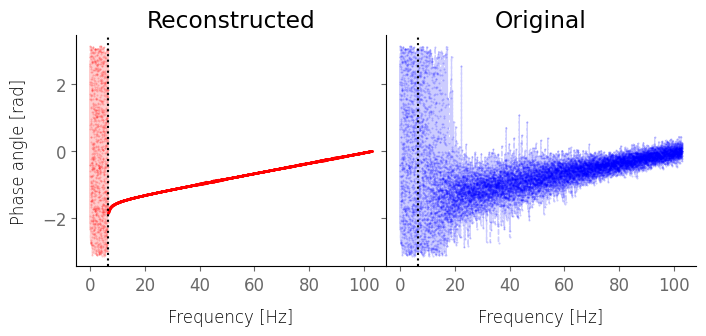

In [30]:
line_dict  = dict(ls='dashed',lw=1,alpha=0.2,marker='.',ms=1)
fig,axs = plt.subplots(1,2,sharey=True,figsize=[8,3],gridspec_kw={"wspace":0})

# Reconstructed
f, Sxx = np.fft.rfftfreq(len(Pnew),d=dT), np.angle(np.fft.rfft(Pnew))
axs[0].plot(f,Sxx,**line_dict,c='r')
axs[0].set(ylabel=r"Phase angle [rad]",title="Reconstructed")

# Original
f, Sxx = fourier.index, np.angle(fourier.iloc[:,nWhich])
axs[1].plot(f,Sxx,**line_dict,c='b')
axs[1].set(title="Original")

for ax in axs: 
    ax.axvline(x=highestFreqCaptured,ls='dotted',c='k')
    ax.set(xscale='linear',yscale='linear',xlabel=r"Frequency [Hz]")

plt.show()

Pickled data for next step

In [31]:
fname = "pickledData_constg/PTX(4).pkl"
with open(fname,'wb') as f: pickle.dump(sampled,f)

### Important numbers to keep

Scale factor needs to be set in the next notebook for writting the C++ code `Write_cpp.ipynb` 

In [32]:
print(f"Scale factor = {len(fourier)}")

Scale factor = 16385


In [33]:
print(f"Number of X = {len(P.columns)}")

Number of X = 51


Delta frequency has to be set in the header pseudofile `calc_signal.H`, variable `delf`

In [34]:
print(f"Delta freq  = {fourier.index[1]}")

Delta freq  = 0.00628677737438413


******
# Power Density Spectra

In [35]:
FOLDER = "surfaceWater/simulations/LES_3D/hot_start/postProcessing/organizedData"
XFILE = f"{FOLDER}/xyz.txt"
X = pd.read_csv(XFILE,sep=" ",names=['X','Y','Z'])
xCoords = pd.DataFrame(X[(X['Z']>0.13) & (X['Z']<0.15)][['X','Y','Z']])

In [36]:
welch_dict = dict(fs=1/dT,scaling='density')

power_ratios = list()
# Reconstruct one signal to visualize
for nWhich,_ in enumerate(P.columns):

    Pnew = reconstruct(time_arr,sampled.index,sampled.iloc[:,nWhich],len(fourier))
    Pold = P.iloc[:,nWhich]

    f,Pxx= welch(Pnew,**welch_dict)
    tot_power_rebuilt = np.trapz(Pxx, f)

    f,Pxx= welch(Pold,**welch_dict)
    tot_power_orig = np.trapz(Pxx, f)

    # Compare total power
    power_ratios.append(tot_power_rebuilt/tot_power_orig)

power_ratios = np.array(power_ratios)

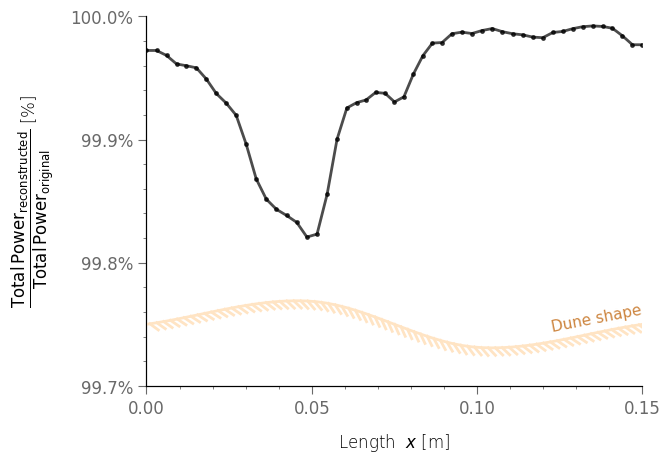

In [38]:
line_dict  = dict(ls='-',marker='.', markersize=5, lw=2, alpha=0.7)
fig,ax = plt.subplots()

ax.plot(P.columns, power_ratios, c='k', **line_dict)

ax2 = ax.twinx()
ax2.plot(
    xCoords['X'],xCoords['Y'], 
    c="bisque", lw=2,
    path_effects = [
        pe.withTickedStroke(offset=(0,0), angle=-45 ,spacing=5, length=1.5)
    ],
    label="Dune shape"
)

ax2.spines.right.set_visible(False)
ax2.yaxis.set_major_locator(NullLocator())
ax2.set_ylim(-0.020, 0.1)
ax2.text(
    1, 0.14, 
    "Dune shape", rotation=11, fontsize=11,
    c="peru", ha="right", va="bottom",
    transform=ax.transAxes
)

# Beautify
ax.set_xlabel("Length\t$x$ [m]")
ax.set_xlim(0, 0.15)

ax.xaxis.set_major_locator(LinearLocator(numticks=4))
ax.xaxis.set_minor_locator(LinearLocator(numticks=16))


## y-label
ax.set_ylabel(r"$\dfrac{{\rm Total \, Power}_{\rm reconstructed}}{{\rm Total \, Power}_{\rm original}}$ [%]")

ax.yaxis.set_major_formatter(PercentFormatter(decimals=1, xmax=1.0, is_latex=True))
ax.yaxis.set_major_locator(LinearLocator(numticks=4))

ax.yaxis.set_minor_locator(LinearLocator(numticks=16))

ax.tick_params(axis='both', which="major", length=6)
ax.tick_params(axis='both', which="minor", length=2)

ax.set_ylim(0.997, 1.0)

#fig.savefig("SI.TotalPowerRatio_overlength.pdf", bbox_inches='tight', pad_inches=0.05)
plt.show()